In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video
from meep.materials import Si, SiO2

Using MPI version 3.1, 1 processes


In [2]:
resolution = 20

dpml = 2
pml_layers = [mp.PML(thickness=dpml)]

sx = 40
sy = 12
cell_size = mp.Vector3(sx+2*dpml,sy)

symmetries = [mp.Mirror(mp.Y)]

In [3]:
W = 1.0 # Width of waveguide in microns

pitch = 0.2*W # pitch of the alligators in microns
L = 30 # Length of cavity in microns
N0 = 20 # Number cycles in "nominal" half cavity (e.g. if there were no chirp, this is how many full waves would stretch across half the cavity)
N1 = 10
thickness = 0.22

In [4]:
# generate grating chirping profile
x = np.linspace(-L/2,L/2,400) #x labels position in the cavity
k = 0.5*(N1/L-N0/L)/L*(x+L/2)+N0/L

# Create polygon vertices
top = -pitch/2*np.cos(2*np.pi*(x+L/2)*k) + W/2 + pitch/2
bottom = pitch/2*np.cos(2*np.pi*(x+L/2)*k) - W/2 - pitch/2

p = list(zip(x,top)) + list(zip(x,bottom))[::-1]

# Add the grating profile
geometry = []

verts = [mp.Vector3(idx[0],idx[1],-thickness/2) for idx in p]
geometry.append(mp.Prism(
    vertices=verts,height=thickness,
    axis=mp.Vector3(0,0,1),material=Si))

geometry += [mp.Block(center=mp.Vector3(0,0,0),size=mp.Vector3(mp.inf,W,mp.inf),material=Si)]

In [5]:
v0 = 0.15  # pulse center frequency
a = 0.2*v0   # Gaussian envelope half-width
b = -0.1  # linear chirp rate (positive: up-chirp, negative: down-chirp)
t0 = 15   # peak time

chirp = lambda t: np.exp(1j*2*np.pi*v0*(t-t0)) * np.exp(-a*(t-t0)**2+1j*b*(t-t0)**2)

kx = 0.4    # initial guess for wavevector in x-direction of eigenmode
kpoint = mp.Vector3(kx)
bnum = 1

sources = [mp.EigenModeSource(src=mp.CustomSource(src_func=chirp,center_frequency=v0),
                    center=mp.Vector3(-0.5*sx + dpml),
                    size=mp.Vector3(y=sy-1),
                    eig_kpoint=kpoint,
                    eig_band=bnum,
                    eig_parity=mp.EVEN_Y+mp.ODD_Z,
                    eig_match_freq=True
                    )]

In [6]:
%%capture
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    resolution=resolution,
                    sources=sources,
                    geometry=geometry,
                    eps_averaging=False,
                    Courant=0.2)


mon_pt_1 = mp.Vector3(-0.5*sx + dpml + 2)
flux = sim.add_flux(v0,0,1,mp.FluxRegion(center=mon_pt_1,size=mp.Vector3(y=sy-1)))

mon_pt_2 = mp.Vector3(0.5*sx - dpml - 2)
flux = sim.add_flux(v0,0,1,mp.FluxRegion(center=mon_pt_2,size=mp.Vector3(y=sy-1)))
#sim.init_sim()

In [7]:

'''f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()'''

'f = plt.figure(dpi=150)\nsim.plot2D(ax=f.gca())\nplt.show()'

In [8]:
fields = []
vol = mp.Volume(center=mp.Vector3(),size=mp.Vector3(x=sx))
def save_fields(sim, todo):
    if todo == 'step':
        fields.append(sim.get_array(vol=vol,component=mp.Ez))

In [9]:
f = plt.figure(dpi=150)
animate = mp.Animate2D(sim,fields=mp.Ez,normalize=True,f=f)
sim.run(mp.at_every(1,animate),mp.at_every(1,save_fields),until=200)
plt.close()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000354854 s
Working in 2D dimensions.
Computational cell is 44 x 12 x 0 with resolution 20
     prism, center = (-1.49214e-15,-3.02536e-17,4.996e-16)
          height 0.22, axis (0,0,1), 800 vertices:
          (-15,0.5,-0.11)
          (-14.9248,0.504913,-0.11)
          (-14.8496,0.519144,-0.11)
          (-14.7744,0.541269,-0.11)
          (-14.6992,0.569098,-0.11)
          (-14.6241,0.5999,-0.11)
          (-14.5489,0.630675,-0.11)
          (-14.4737,0.658442,-0.11)
          (-14.3985,0.680528,-0.11)
          (-14.3233,0.694827,-0.11)
          (-14.2481,0.699993,-0.11)
          (-14.1729,0.695565,-0.11)
          (-14.0977,0.682002,-0.11)
          (-14.0226,0.660633,-0.11)
          (-13.9474,0.63352,-0.11)
          (-13.8722,0.603258,-0.11)
          (-13.797,0.572726,-0.11)
          (-13.7218,0.544807,-0.11)
          (-13.6466,0.522122,-0.11)
          (-13.5714,0.506783,-0.11)
          (-13.4962,0

          (1.69173,0.687641,-0.11)
          (1.76692,0.674546,-0.11)
          (1.84211,0.657654,-0.11)
          (1.91729,0.637847,-0.11)
          (1.99248,0.616149,-0.11)
          (2.06767,0.593669,-0.11)
          (2.14286,0.571547,-0.11)
          (2.21805,0.550896,-0.11)
          (2.29323,0.532745,-0.11)
          (2.36842,0.517988,-0.11)
          (2.44361,0.507342,-0.11)
          (2.5188,0.501316,-0.11)
          (2.59398,0.500182,-0.11)
          (2.66917,0.503972,-0.11)
          (2.74436,0.512472,-0.11)
          (2.81955,0.525242,-0.11)
          (2.89474,0.541637,-0.11)
          (2.96992,0.560839,-0.11)
          (3.04511,0.581905,-0.11)
          (3.1203,0.603807,-0.11)
          (3.19549,0.625487,-0.11)
          (3.27068,0.645907,-0.11)
          (3.34586,0.664099,-0.11)
          (3.42105,0.67921,-0.11)
          (3.49624,0.690539,-0.11)
          (3.57143,0.697571,-0.11)
          (3.64662,0.699999,-0.11)
          (3.7218,0.697734,-0.11)
          (3.79699,0.690

          (10.7143,-0.698156,-0.11)
          (10.6391,-0.693142,-0.11)
          (10.5639,-0.685092,-0.11)
          (10.4887,-0.674248,-0.11)
          (10.4135,-0.660949,-0.11)
          (10.3383,-0.645616,-0.11)
          (10.2632,-0.628742,-0.11)
          (10.188,-0.610878,-0.11)
          (10.1128,-0.592614,-0.11)
          (10.0376,-0.574557,-0.11)
          (9.96241,-0.557318,-0.11)
          (9.88722,-0.541483,-0.11)
          (9.81203,-0.527599,-0.11)
          (9.73684,-0.516151,-0.11)
          (9.66165,-0.507547,-0.11)
          (9.58647,-0.5021,-0.11)
          (9.51128,-0.500018,-0.11)
          (9.43609,-0.501396,-0.11)
          (9.3609,-0.506205,-0.11)
          (9.28571,-0.514302,-0.11)
          (9.21053,-0.525421,-0.11)
          (9.13534,-0.53919,-0.11)
          (9.06015,-0.555139,-0.11)
          (8.98496,-0.572715,-0.11)
          (8.90977,-0.5913,-0.11)
          (8.83459,-0.610235,-0.11)
          (8.7594,-0.62884,-0.11)
          (8.68421,-0.646443,-0.11)
 

          (-6.35338,-0.658297,-0.11)
          (-6.42857,-0.634537,-0.11)
          (-6.50376,-0.608238,-0.11)
          (-6.57895,-0.581304,-0.11)
          (-6.65414,-0.555694,-0.11)
          (-6.72932,-0.533287,-0.11)
          (-6.80451,-0.515741,-0.11)
          (-6.8797,-0.504366,-0.11)
          (-6.95489,-0.500029,-0.11)
          (-7.03008,-0.50308,-0.11)
          (-7.10526,-0.513325,-0.11)
          (-7.18045,-0.530032,-0.11)
          (-7.25564,-0.551983,-0.11)
          (-7.33083,-0.577557,-0.11)
          (-7.40602,-0.604852,-0.11)
          (-7.4812,-0.631819,-0.11)
          (-7.55639,-0.656422,-0.11)
          (-7.63158,-0.676791,-0.11)
          (-7.70677,-0.691359,-0.11)
          (-7.78195,-0.698995,-0.11)
          (-7.85714,-0.699085,-0.11)
          (-7.93233,-0.691592,-0.11)
          (-8.00752,-0.677058,-0.11)
          (-8.08271,-0.656572,-0.11)
          (-8.15789,-0.631691,-0.11)
          (-8.23308,-0.604323,-0.11)
          (-8.30827,-0.576582,-0.11)
    

In [10]:
filename = 'media/chirp.mp4'
animate.to_mp4(5,filename)

Generating MP4...


In [11]:
Video(filename)

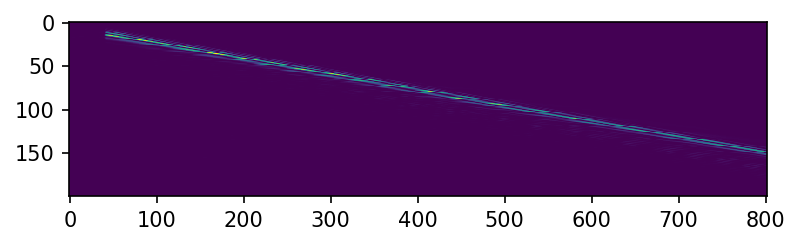

In [22]:
temp = np.array(np.abs(fields)**2) / max(np.array(np.abs(fields)**2).flatten())
plt.figure(dpi = 150)
plt.imshow((temp))
plt.show()

In [35]:
from matplotlib import animation
x,y,z,w = sim.get_array_metadata(vol)

fig, ax = plt.subplots(dpi=150)
xdata, ydata = x, temp[0,:]
ln, = plt.plot(xdata, ydata, 'r')
plt.ylim(0,1)

def update(frame):
    xdata, ydata = x, temp[frame,:]
    ln.set_data(xdata, ydata)
    return ln,

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

ani = animation.FuncAnimation(fig, update, frames=range(0,len(fields)), blit=False)
ani.save('media/chirp_time.mp4', writer=writer)
plt.close()

In [34]:
Video('media/chirp_time.mp4')